In [16]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "earthquake"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

## Importing data and looking at it

In [17]:
import pandas as pd

def load_data(data_path = "datasets"):
    csv_path_train = os.path.join(data_path, "train.csv")
#    csv_path_test = os.path.join(data_path, "test.csv")
    csv_path_sample_submission = os.path.join(data_path, "sample_submission.csv")
    return pd.read_csv(csv_path_train), pd.read_csv(csv_path_sample_submission)

In [18]:
def load_test(data_path = "datasets/test"):
    num_files = len(os.listdir(data_path))
    test_list = []
    for path in os.listdir(data_path):
        csv_path = os.path.join(data_path, path)
        test_list.append(pd.read_csv(csv_path))
    return test_list

In [19]:
train, sample = load_data()

In [20]:
test = load_test()

In [21]:
train.head()

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


In [22]:
print("Number of test files", len(test))

Number of test files 2624


In [23]:
test[0].head()

,acoustic_data
0,2
1,6
2,5
3,6
4,9


In [24]:
train.describe()

,acoustic_data,time_to_failure
count,6.291455e+08,6.291455e+08
mean,4.519468e+00,5.678292e+00
std,1.073571e+01,3.672697e+00
min,-5.515000e+03,9.550396e-05
25%,2.000000e+00,2.625997e+00
50%,5.000000e+00,5.349798e+00
75%,7.000000e+00,8.173396e+00
max,5.444000e+03,1.610740e+01


In [29]:
for i in range(3):
    print(test[i].describe(),'\n')

       acoustic_data
count  150000.000000
mean        4.333713
std         6.130020
min      -176.000000
25%         2.000000
50%         4.000000
75%         7.000000
max       185.000000 

       acoustic_data
count  150000.000000
mean        3.749993
std        13.897649
min      -353.000000
25%         1.000000
50%         4.000000
75%         6.000000
max       605.000000 

       acoustic_data
count  150000.000000
mean        4.107000
std         4.333725
min       -42.000000
25%         2.000000
50%         4.000000
75%         6.000000
max        54.000000 



In [90]:
t = int(5656565)
for i in range(t,t+20):
    ad, ttf = train["acoustic_data"][i], train["time_to_failure"][i]
    print("ad: ", ad, "\t ttf: ", ttf)

ad:  7 	 ttf:  0.0007954886232300001
ad:  2 	 ttf:  0.0007954875231900001
ad:  2 	 ttf:  0.00079548642316
ad:  0 	 ttf:  0.0007954853235800001
ad:  0 	 ttf:  0.00079548422309
ad:  2 	 ttf:  0.00079548312351
ad:  4 	 ttf:  0.0007954820230200001
ad:  5 	 ttf:  0.00079548092344
ad:  4 	 ttf:  0.0007954798229500001
ad:  4 	 ttf:  11.540799987
ad:  5 	 ttf:  11.540799986
ad:  6 	 ttf:  11.540799984000001
ad:  3 	 ttf:  11.540799983
ad:  4 	 ttf:  11.540799982000001
ad:  3 	 ttf:  11.540799981
ad:  8 	 ttf:  11.54079998
ad:  8 	 ttf:  11.540799979
ad:  10 	 ttf:  11.540799977999999
ad:  7 	 ttf:  11.540799977
ad:  6 	 ttf:  11.540799975999999


In [163]:
def plot_activity(t_init, duration, x_scale=None):
    if x_scale:
        plt.figure(figsize=(4*x_scale,4))
    plt.plot(train["acoustic_data"][t_init:(t_init+duration)], 'b--')
    plt.plot(train["time_to_failure"][t_init:(t_init+duration)], 'ro')
    plt.xlabel("time", fontsize=10)
    plt.ylabel("acoustic data", fontsize=10)
    plt.show()

In [183]:
def plot_activity(t_init, duration, x_scale=None):
    if x_scale:
        fig, ax1 = plt.subplots(figsize=(4*x_scale,4))
    else:
        fig, ax1 = plt.subplots()

#    color = 'tab:red'
    ax1.set_xlabel('time (s)', fontsize=15)
    ax1.set_ylabel("acoustic data", fontsize=15, color='b')
    ax1.plot(train["acoustic_data"][t_init:(t_init+duration)], 'b--')
#    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

#    color = 'tab:blue'
    ax2.set_ylabel('ttf', fontsize=15, color='r')
    ax2.plot(train["time_to_failure"][t_init:(t_init+duration)], 'ro')
#    ax2.tick_params(axis='y', labelcolor=color)

#    fig.tight_layout()
    plt.show()

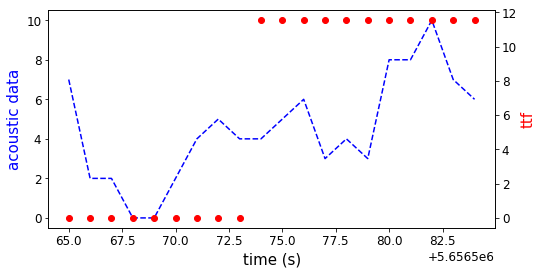

In [184]:
plot_activity(5656565, 20, x_scale=2)

In [114]:
m = len(train)

In [129]:
train0 = np.array(train["time_to_failure"])[:(m-1)]
train1 = np.array(train["time_to_failure"])[1:]

In [130]:
jumps0 = (train0 < train1)

In [138]:
jumps = np.where(jumps0 == 1)[0]

In [141]:
jumps

array([  5656573,  50085877, 104677355, 138772452, 187641819, 218652629,
       245829584, 307838916, 338276286, 375377847, 419368879, 461811622,
       495800224, 528777114, 585568143, 621985672])

In [142]:
n_jumps = len(jumps)
n_jumps

16

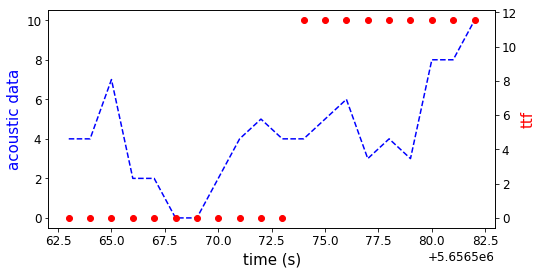

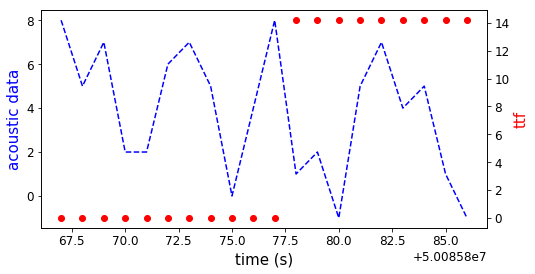

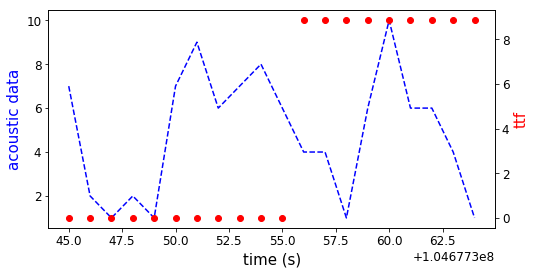

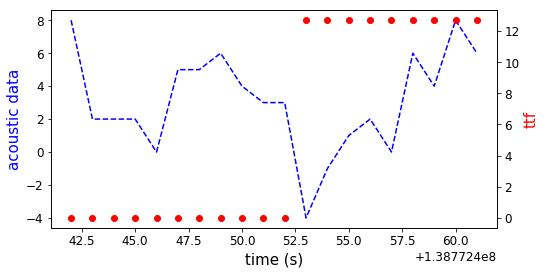

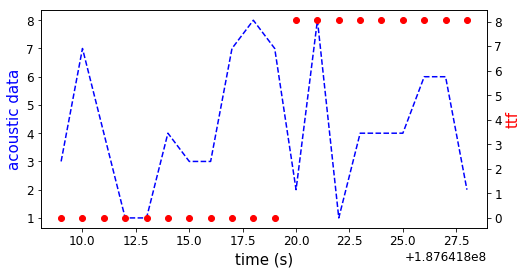

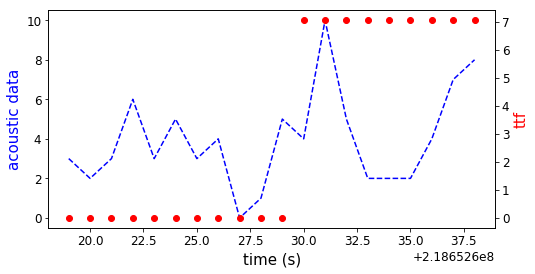

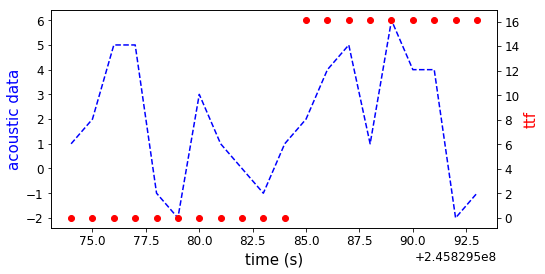

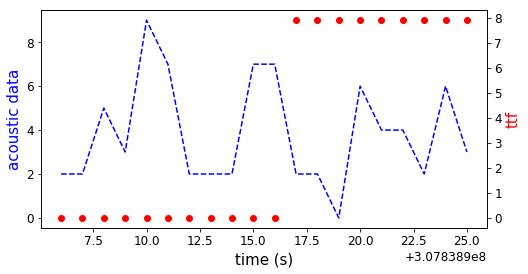

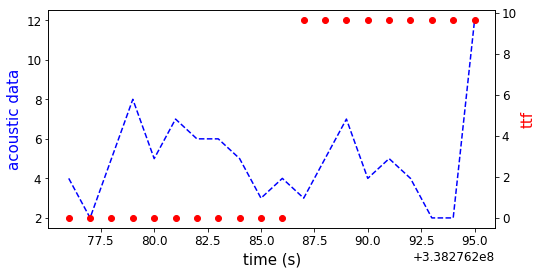

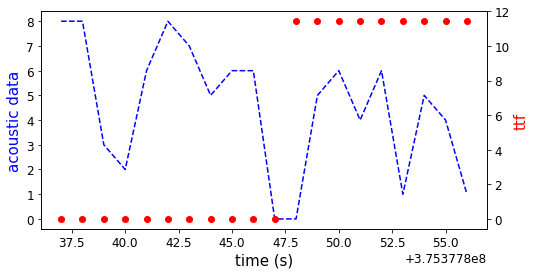

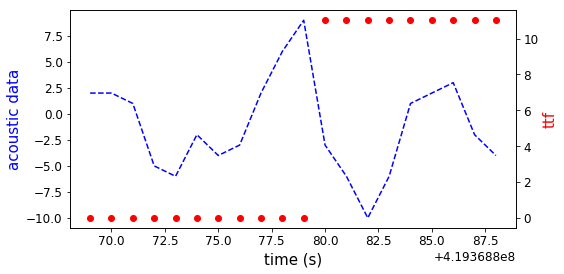

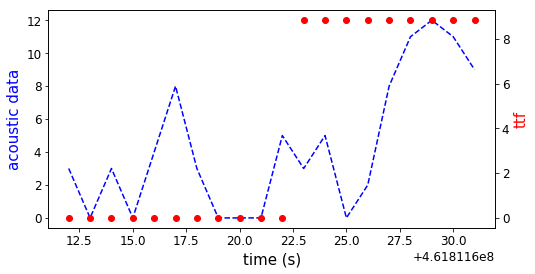

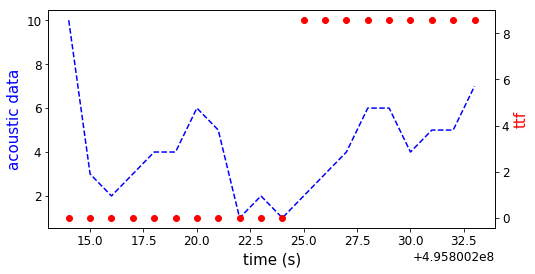

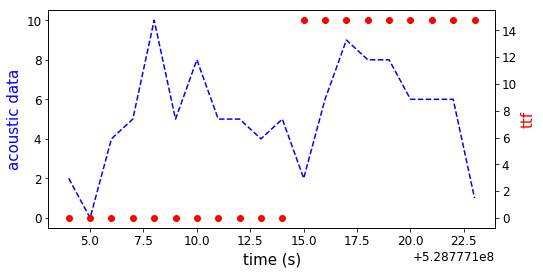

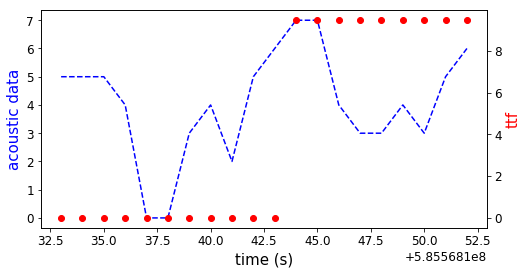

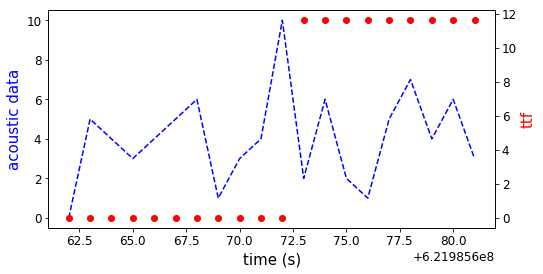

In [185]:
for i in range(n_jumps):
    plot_activity(jumps[i]-10, 20, x_scale = 2)

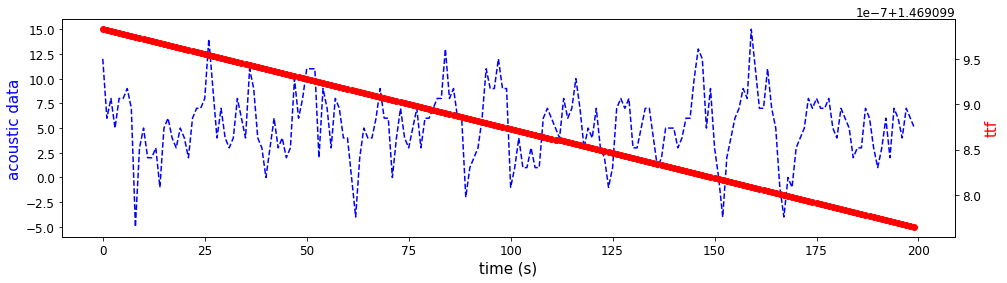

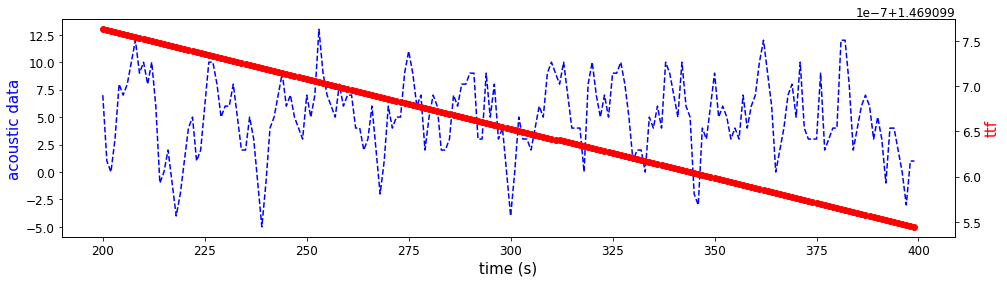

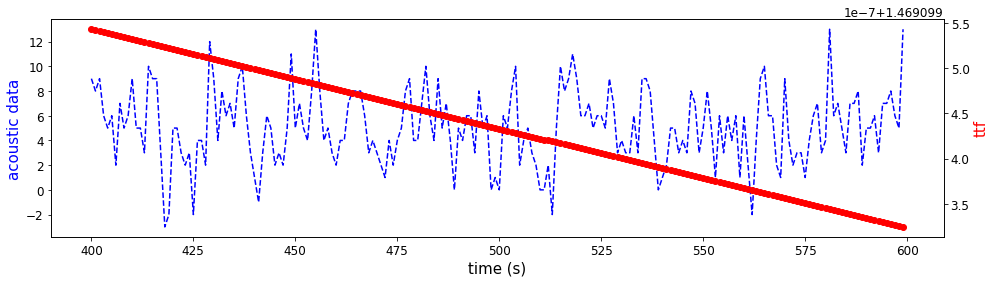

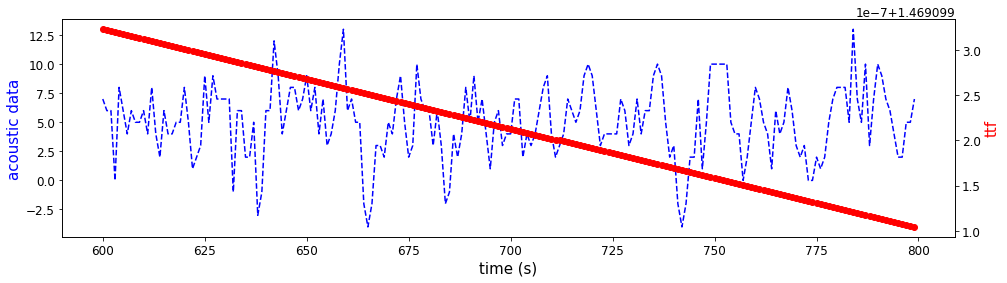

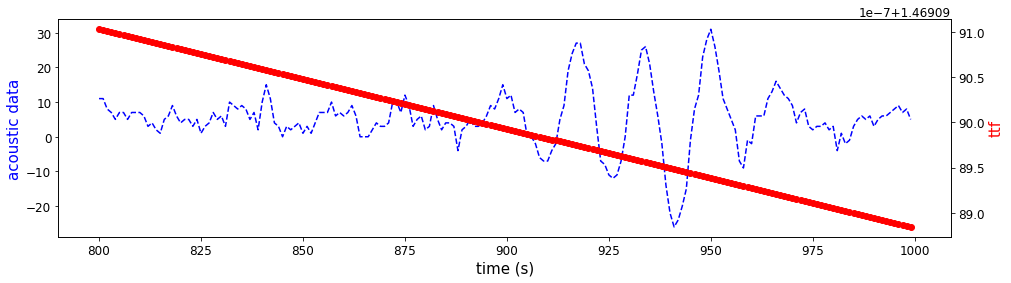

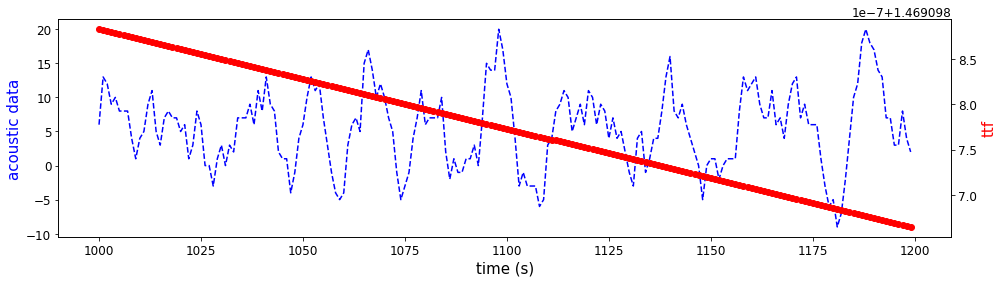

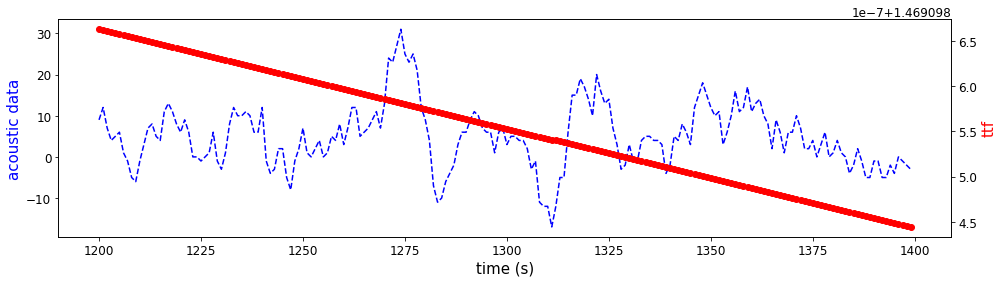

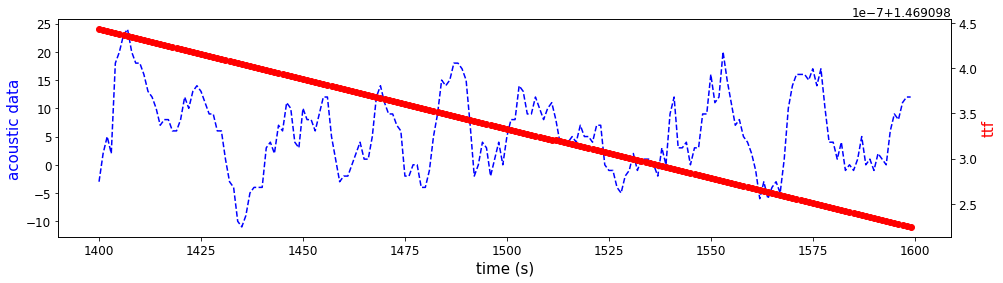

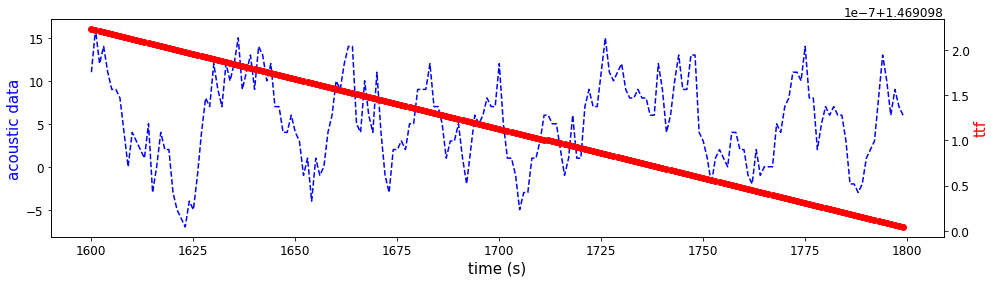

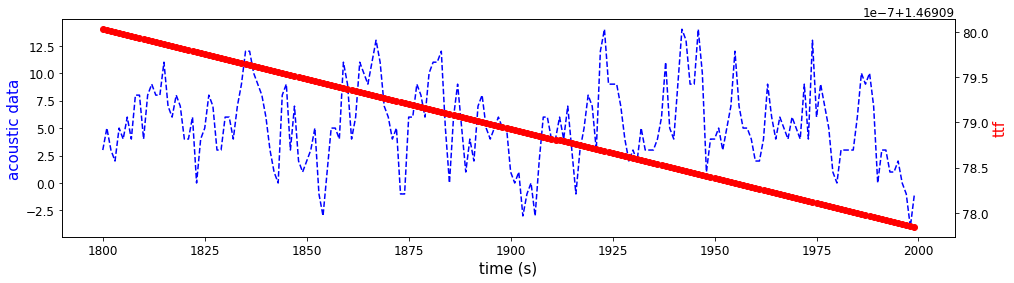

In [186]:
for i in range(10):
    plot_activity(i*200,200, x_scale=4)

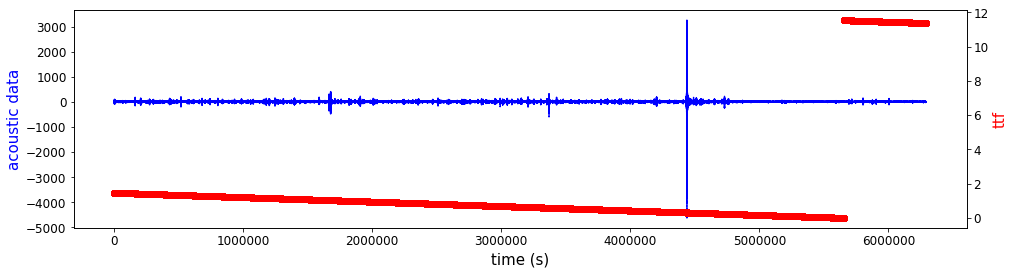

In [187]:
plot_activity(0,int(m/100), x_scale=4)

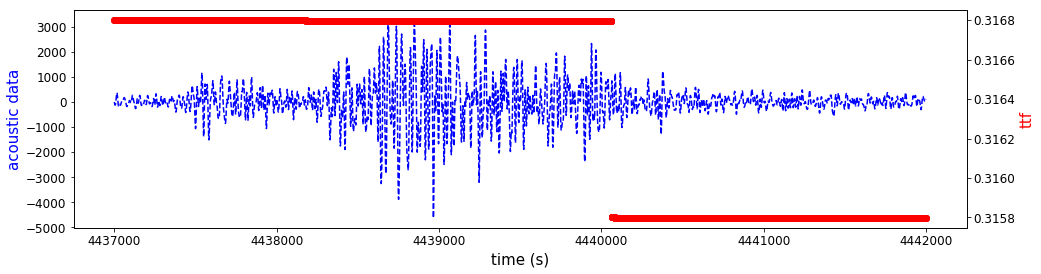

In [188]:
plot_activity(4437000, 5000, x_scale=4)